## Introduction

Last.fm is a music website founded in the United Kingdom in 2002. Using a music recommender system called "Audioscrobbler", it builds a detailed profile of each user's musical taste by recording details of the tracks the user listens to, either from Internet radio stations, or the user's computer or many portable music devices. This information is transferred ("scrobbled") to Last.fm's database either via the music player (including, among others Spotify, Deezer, Tidal, MusicBee, and Anghami) or via a plug-in installed into the user's music player. The data are then displayed on the user's profile page and compiled to create reference pages for individual artists. [Link is here](https://www.last.fm/api/intro)
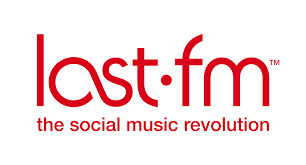

Content of this analysis: 
- 50 Top artists around the world
- Origins of artists
- Albums and singles of artist
- Top tags in albums

## Import working libraries

In [1]:
from IPython.display import HTML
import pandas as pd
import requests
import time
import json
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
from plotly.subplots import make_subplots
import chart_studio.plotly as py
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objects as go
import pycountry
%matplotlib inline
pd.options.display.max_columns=30
init_notebook_mode(connected=True)
cf.go_offline(connected=True)
cf.set_config_file(theme="pearl")

In [2]:
# Create a function to make requests from Lastfm
def req(params):
    api_key = "ad50ff96f7a5a9e5e0ab3c253b291e24"
    querystring = {"api_key": api_key, "format":"json", **params}
    url = "http://ws.audioscrobbler.com/2.0/"
    response = requests.get(url, params=querystring)
    return response.json()

#to print json file in a nice format
def pj(data):
    print(json.dumps(data, indent = 2))

## Data analysis

### Top artists

In the first section, I will make request to get the top 50 artists in Last.fm. The only requirement in this request is to pass the method **chart.gettopartists**

In [3]:
top_artists = req({'method':'chart.gettopartists'})
top_artists = top_artists['artists']['artist']

In [4]:
top_artist_dict = {'name': [], 'play_count': [], 'listeners': []}
for artist in top_artists:
    top_artist_dict['name'].append(artist['name'])
    top_artist_dict['play_count'].append(artist['playcount'])
    top_artist_dict['listeners'].append(artist['listeners'])


In [5]:
top_artist_df = pd.DataFrame(data = top_artist_dict) #create a dataframe for top_artist_dict

In [37]:
top_artist_df.iplot(kind = 'bar', x = 'name', y = 'play_count', secondary_y = 'listeners', 
                    title = 'Play count and listeners of top artists', xTitle = 'Top artists',
                   yTitle = 'Play count', secondary_y_title = 'Listeners')

<div style="background-color:powderblue;">
    <ul>
        <li><b>Coldplay</b> got the highest play count when there was more than 500m. Come next are <b>Kanye West, Queen, Rihanna, Radio head and Eminen</b> when then number of play count almost reached 500m.</li>
        <li>Top listeners belongs to <b>The Beatles, Radio Head and BTS (over 5M)</b></li>
    </ul>
</div>


In [7]:
top_artist_df['rate'] = top_artist_df['play_count'].astype('int')/ top_artist_df['listeners'].astype('int')
top_artist_df.iplot(kind = 'bar', x = 'name', y= 'rate', xTitle = 'Name of artists', 
                    yTitle = 'Play count per listener', colors ={'rate': 'Red'} )

 <html>
    <body>
        <p style="background-color:powderblue;" ><b>BTS</b> has a significant rate in comparison to other artists. The average play count of each listener is 983 while others is under 200. This means that the listener from BTS Korea bandgroup has played theirs song multiple times.</p>
                  </body>
                  </html>

### Artist origins

The default limit of **chart.gettopartists** is 50, however, I would like to increase to 500 artists in this part in order to find the artist origins. Since Lastfm does not provide the artist origins, it is neccesary to find another website and Musicbrainz comes in hand, the requirement is artist's mbid (id). [Link](https://musicbrainz.org/doc/MusicBrainz_API)

In [8]:
artists = req({'method':'chart.gettopartists', 'limit': 500})
artist_dict = {'name': [], 'play_count': [], 'listeners': []}
for artist in artists['artists']['artist']:
    artist_dict['name'].append(artist['name'])
    artist_dict['play_count'].append(artist['playcount'])
    artist_dict['listeners'].append(artist['listeners'])
artist_df = pd.DataFrame(data = artist_dict)

In [9]:
# there are several artists missing mbid, I used filter to make a list of artist without mbid
artists_without_mbid = list(filter(lambda a: a["mbid"] == "", artists['artists']['artist']))
#pj(list(map(lambda a: a["name"], artists_without_mbid)))
mbid_dict = { }

for artist in artists_without_mbid:
    time.sleep(1) #because of the request limitation from music brainz
    info = requests.get(f"http://musicbrainz.org/ws/2/artist/?query={artist['name']}&fmt=json&limit=1", 
                        headers = {'user-agent': 'Integrify.io Assignment/1.0.0 (nhu.nguyen@integrify.io)'})
    info = info.json()
    mbid_dict[artist['name']] = info['artists'][0]['id']

In [10]:
areas = []
incompleted = []

# o = [{ "mbid": "9f1195cf-9900-45db-bf9c-21c205672ae0", "name": "Future" }]

for artist in artists['artists']['artist']:
    time.sleep(0.5)
        
    if artist['mbid'] != '':
        mbid = artist["mbid"]
    else: 
        mbid = mbid_dict[artist['name']]

    info = requests.get(f"https://musicbrainz.org/ws/2/artist/{mbid}?fmt=json", 
                        headers = {'user-agent': 'Integrify.io Assignment/1.0.0 (nhu.nguyen@integrify.io)'})
    info = info.json()
    if 'area' in info and info['area'] != None and "iso-3166-1-codes" in info["area"]: #check if the iso code is available
        areas.append({ "mbid": mbid, "name": info["name"], "iso": info["area"]["iso-3166-1-codes"][0] })
    else:
        incompleted.append(info)

In [38]:
artist_country = pd.DataFrame(data = areas)
combine = artist_country.merge(artist_df)
combine.shape

(418, 5)

In [85]:
iso_3 = []
for i in combine['iso']:
    a = pycountry.countries.get(alpha_2 = i) #use pycountry to change the alpha 2 to alpha 3 ISO code
    iso_3.append(a.alpha_3)
combine['iso_3'] = iso_3
combine_gb = combine.groupby('iso_3').sum()
combine_gb.reset_index(inplace = True)

In [90]:
fig = go.Figure(data=go.Choropleth(
    locations= combine_gb['iso_3'], # Spatial coordinates
    z = combine_gb['play_count'], # Data to be color-coded
    locationmode = 'ISO-3', # set of locations match entries in `locations`
    colorscale = 'Reds',
     colorbar_title = "Play Counts",
))

fig.update_layout(
    title_text = 'Play counts of top artists',
    geo_scope='world'
)

fig.show()

### All albums and singles of a singer

In this section, I selected to analyze all albums and singles of Katy Perry

In [16]:
perry = req({"method":"artist.getinfo", "artist": "Katy Perry"})
perry = perry["artist"]

In [31]:
top_albums = req({ "method": "artist.gettopalbums", "mbid": perry["mbid"] })

data = {'name': [], "play_count": [], "id": []}

for album in top_albums["topalbums"]["album"]:
    data["name"].append(album["name"])
    data["play_count"].append(album["playcount"])
    data["id"].append(album["mbid"] if "mbid" in album else None)

df = pd.DataFrame(data=data)
df = df.sort_values(by = ['play_count'], ascending = False)
df.name  = df.name.str.title()

In [32]:
fig = px.bar(df.head(20), x = df.head(20).name, y = df.head(20).play_count)
fig.update_layout(title = "Katy Perry's top albums",
                  yaxis_title = "Play count",
                  xaxis_title = 'Name of Albums')

<html>
    <body>
        <p style="background-color:powderblue;" >The chart shows top 20 albums and singles from Katy Perry. In which <b>Teanager Dream</b> is the most popular one with the number of play count is more than 30M. <b>One Of The Boys</b> comes at the second with near 30M play counts.</p>
                  </body>
                  </html>

### Top tags

In the final section, I will collect the data from album.gettoptags. The requirements are the album's name and the artist name. 

In [19]:
tags = []
for album in top_albums["topalbums"]["album"][0:2]: # get the top tags of two popular albums
    res = req({"method": "album.gettoptags", "artist": album["artist"]["name"], "album": album["name"]})
    tags += res["toptags"]["tag"]

In [20]:
tag_data = {'count' : [], 'name': [], 'url': []} 
for tag in tags:
    tag_data['count'].append(tag['count'])
    tag_data['name'].append(tag['name'])
    tag_data['url'].append(tag['url'])

In [21]:
tag_data = pd.DataFrame(data = tag_data)
tag_data.sort_values(by = ['count'], ascending = False)

,count,name,url
0,100,pop,https://www.last.fm/tag/pop
100,100,pop,https://www.last.fm/tag/pop
101,95,albums I own,https://www.last.fm/tag/albums+I+own
1,81,albums I own,https://www.last.fm/tag/albums+I+own
102,69,katy perry,https://www.last.fm/tag/katy+perry
...,...,...,...
75,1,80,https://www.last.fm/tag/80
74,1,dance pop,https://www.last.fm/tag/dance+pop
73,1,vinyl,https://www.last.fm/tag/vinyl
72,1,buy,https://www.last.fm/tag/buy


The top is ordered by the popularity, the most one will be counted as 100

In [22]:
tag_data.name = tag_data.name.astype('string')

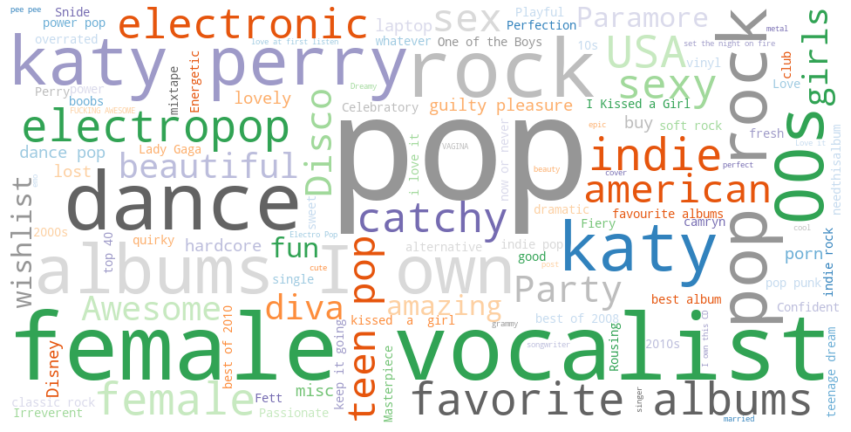

In [23]:
text = tag_data.name

# Create and generate a word cloud image:
wordcloud = WordCloud(background_color = 'white', colormap='tab20c', width = 960,
                      height = 480, collocations= False, regexp=r"\w[\w' ]+").generate(('+').join(text))

# Display the generated image:
plt.figure(figsize = (15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

 <html>
    <body>
        <p style="background-color:powderblue;" >The main tags appears in two selected albums from Katy Perry are <b> Female vocalist, album I own, dance or catchy</b></p>
                  </body>
                  </html>